In [ ]:
import os, random, math, time, json
from dataclasses import dataclass, asdict
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

!pip -q install umap-learn

import torchvision
import torchvision.transforms as T
from torchvision.models import resnet152, ResNet152_Weights
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

In [ ]:
SEED = 42

def seed_all(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_all()

assert torch.cuda.is_available(), "GPU not enabled. Go to Runtime → Change runtime type → GPU"
device = torch.device("cuda:0")
print("Using device:", torch.cuda.get_device_name(0))

OUT_ROOT = Path("/content/task1_runs")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

Using device: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
OUT_ROOT = Path("/content/drive/MyDrive/AI623_Task1")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

Mounted at /content/drive


In [ ]:
def get_cifar10_loaders(data_dir="/content/data", batch_size=64, num_workers=0):
    train_tfms = T.Compose([
        T.Resize(224),
        T.RandomHorizontalFlip(),
        T.RandomCrop(224, padding=8),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    val_tfms = T.Compose([
        T.Resize(224),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

    train_ds = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_tfms)
    val_ds   = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=val_tfms)

    train_loader = torch.utils.data.DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    val_loader = torch.utils.data.DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    return train_loader, val_loader

train_loader, val_loader = get_cifar10_loaders(batch_size=64)
classes = train_loader.dataset.classes
len(classes), classes[:5]

(10, ['airplane', 'automobile', 'bird', 'cat', 'deer'])

In [ ]:
def build_resnet152(num_classes=10, weights="imagenet"):
    if weights == "imagenet":
        w = ResNet152_Weights.DEFAULT
        model = resnet152(weights=w)
    elif weights == "random":
        model = resnet152(weights=None)
    else:
        raise ValueError("weights must be 'imagenet' or 'random'")

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

def set_train_mode(model, mode="head_only"):
    for p in model.parameters():
        p.requires_grad = False

    if mode == "head_only":
        for p in model.fc.parameters():
            p.requires_grad = True
    elif mode == "last_block":
        for p in model.layer4.parameters():
            p.requires_grad = True
        for p in model.fc.parameters():
            p.requires_grad = True
    elif mode == "full":
        for p in model.parameters():
            p.requires_grad = True
    else:
        raise ValueError("mode must be head_only / last_block / full")

In [ ]:
from torchvision.models.resnet import Bottleneck

def get_block_by_name(model, name: str):
    layer_name, idx_str = name.split(".")
    layer = getattr(model, layer_name)
    return layer[int(idx_str)]

def disable_skip_in_blocks(model, block_names):
    for bn in block_names:
        block = get_block_by_name(model, bn)
        if not isinstance(block, Bottleneck):
            raise TypeError(f"{bn} is not a Bottleneck block in this model.")

        if not hasattr(block, "_orig_forward"):
            block._orig_forward = block.forward

        def forward_no_skip(self, x):
            identity = x

            out = self.conv1(x); out = self.bn1(out); out = self.relu(out)
            out = self.conv2(out); out = self.bn2(out); out = self.relu(out)
            out = self.conv3(out); out = self.bn3(out)

            if self.downsample is not None:
                identity = self.downsample(x)

            out = self.relu(out)
            return out

        block.forward = forward_no_skip.__get__(block, block.__class__)
    return model

In [ ]:
from torchvision.models.resnet import Bottleneck

def get_block_by_name(model, name: str):
    layer_name, idx_str = name.split(".")
    layer = getattr(model, layer_name)
    return layer[int(idx_str)]

def disable_skip_in_blocks(model, block_names):
    """
    block_names: list like ["layer3.5", "layer3.6"]
    Removes: out += identity (skip add) inside those Bottleneck blocks.
    """
    for bn in block_names:
        block = get_block_by_name(model, bn)
        if not isinstance(block, Bottleneck):
            raise TypeError(f"{bn} is not a Bottleneck block in this model.")

        if not hasattr(block, "_orig_forward"):
            block._orig_forward = block.forward

        def forward_no_skip(self, x):
            identity = x

            out = self.conv1(x); out = self.bn1(out); out = self.relu(out)
            out = self.conv2(out); out = self.bn2(out); out = self.relu(out)
            out = self.conv3(out); out = self.bn3(out)

            if self.downsample is not None:
                identity = self.downsample(x)

            out = self.relu(out)
            return out

        block.forward = forward_no_skip.__get__(block, block.__class__)
    return model

In [ ]:
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, total_correct / total

def train_one_epoch(model, loader, criterion, optimizer, scaler=None):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        if scaler is None:
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
        else:
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss / total, total_correct / total

def run_experiment(
    exp_name,
    weights="imagenet",
    train_mode="head_only",
    disable_skips=None,
    epochs=5,
    batch_size=64,
    lr=1e-3,
    wd=1e-4,
    use_amp=True
):
    exp_dir = OUT_ROOT / "runs" / exp_name
    exp_dir.mkdir(parents=True, exist_ok=True)

    train_loader, val_loader = get_cifar10_loaders(batch_size=batch_size)

    model = build_resnet152(num_classes=10, weights=weights)
    if disable_skips:
        model = disable_skip_in_blocks(model, disable_skips)
    set_train_mode(model, train_mode)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(params, lr=lr, weight_decay=wd)

    scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type == "cuda") else None

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val = -1.0
    best_path = exp_dir / "best.pt"

    config = dict(
        exp_name=exp_name,
        weights=weights,
        train_mode=train_mode,
        disable_skips=disable_skips,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        wd=wd,
        use_amp=bool(scaler is not None),
        seed=SEED,
    )
    (exp_dir / "config.json").write_text(json.dumps(config, indent=2))

    for ep in range(1, epochs+1):
        t0 = time.time()
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler=scaler)
        va_loss, va_acc = evaluate(model, val_loader, criterion)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        if va_acc > best_val:
            best_val = va_acc
            torch.save({"model": model.state_dict(), "config": config}, best_path)

        print(f"[{exp_name}] Epoch {ep:02d}/{epochs} | "
              f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
              f"val loss {va_loss:.4f} acc {va_acc:.4f} | "
              f"{time.time()-t0:.1f}s")

    import pandas as pd
    df = pd.DataFrame(history)
    df.to_csv(exp_dir / "metrics.csv", index=False)

    plt.figure()
    plt.plot(df["train_acc"], label="train_acc")
    plt.plot(df["val_acc"], label="val_acc")
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend()
    plt.title(exp_name)
    plt.tight_layout()
    plt.savefig(exp_dir / "acc_curve.png", dpi=200)
    plt.show()

    return exp_dir

/tmp/ipython-input-951386095.py:69: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type == "cuda") else None
/tmp/ipython-input-951386095.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[baseline_pretrained_head] Epoch 01/3 | train loss 0.6264 acc 0.8146 | val loss 0.4643 acc 0.8537 | 325.8s
[baseline_pretrained_head] Epoch 02/3 | train loss 0.4357 acc 0.8573 | val loss 0.4209 acc 0.8655 | 338.4s
[baseline_pretrained_head] Epoch 03/3 | train loss 0.4072 acc 0.8642 | val loss 0.4062 acc 0.8684 | 321.8s


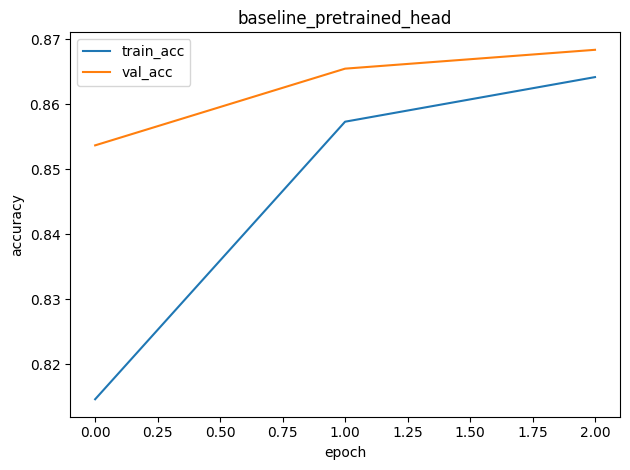

[baseline_random_head] Epoch 01/3 | train loss 2.3727 acc 0.1301 | val loss 2.3745 acc 0.1348 | 323.7s
[baseline_random_head] Epoch 02/3 | train loss 2.3551 acc 0.1405 | val loss 2.2911 acc 0.1386 | 324.9s
[baseline_random_head] Epoch 03/3 | train loss 2.3340 acc 0.1486 | val loss 2.3266 acc 0.1345 | 321.6s


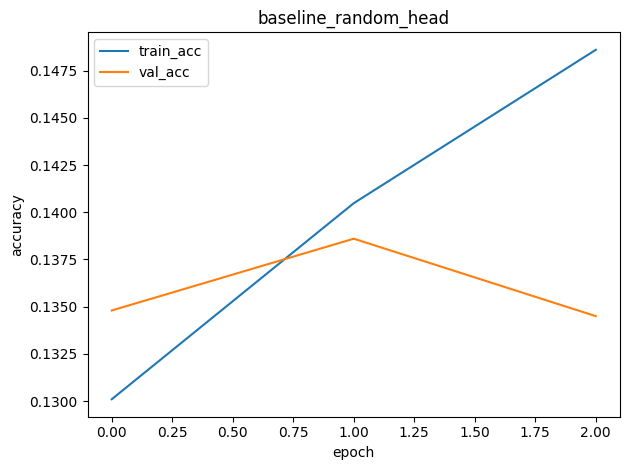

In [ ]:
dir_baseline_pre = run_experiment(
    exp_name="baseline_pretrained_head",
    weights="imagenet",
    train_mode="head_only",
    epochs=3,
    batch_size=64,
    lr=1e-3,
)

dir_baseline_rand = run_experiment(
    exp_name="baseline_random_head",
    weights="random",
    train_mode="head_only",
    epochs=3,
    batch_size=64,
    lr=1e-3,
)

/tmp/ipython-input-951386095.py:69: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type == "cuda") else None
/tmp/ipython-input-951386095.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[noskip_layer3_5_6_7] Epoch 01/2 | train loss 2.2902 acc 0.1309 | val loss 2.2654 acc 0.1399 | 318.7s
[noskip_layer3_5_6_7] Epoch 02/2 | train loss 2.2730 acc 0.1458 | val loss 2.2606 acc 0.1499 | 325.1s


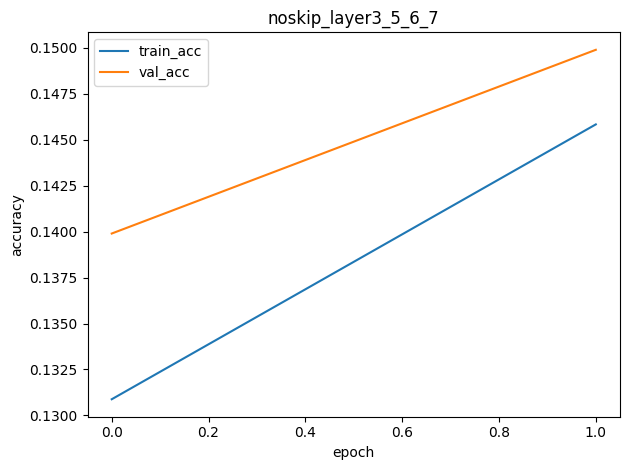

In [ ]:
dir_noskip = run_experiment(
    exp_name="noskip_layer3_5_6_7",
    weights="imagenet",
    train_mode="head_only",
    disable_skips=["layer3.5", "layer3.6", "layer3.7"],
    epochs=2,
    batch_size=64,
    lr=1e-3,
)

/tmp/ipython-input-951386095.py:69: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type == "cuda") else None
/tmp/ipython-input-951386095.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[finetune_last_block] Epoch 01/2 | train loss 0.3242 acc 0.8930 | val loss 0.2214 acc 0.9246 | 350.6s
[finetune_last_block] Epoch 02/2 | train loss 0.1852 acc 0.9361 | val loss 0.1938 acc 0.9375 | 341.1s


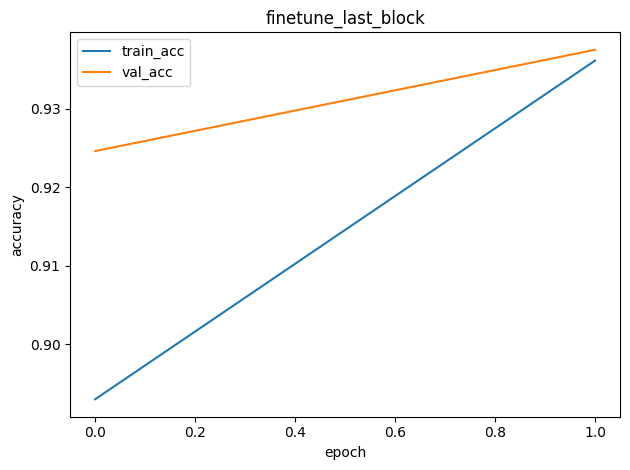

In [ ]:
dir_lastblock = run_experiment(
    exp_name="finetune_last_block",
    weights="imagenet",
    train_mode="last_block",
    epochs=2,
    batch_size=48,
    lr=1e-3,
)

/tmp/ipython-input-951386095.py:69: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type == "cuda") else None
/tmp/ipython-input-951386095.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[finetune_full] Epoch 01/2 | train loss 0.4015 acc 0.8658 | val loss 0.2922 acc 0.9004 | 638.9s
[finetune_full] Epoch 02/2 | train loss 0.2457 acc 0.9172 | val loss 0.2523 acc 0.9166 | 630.8s


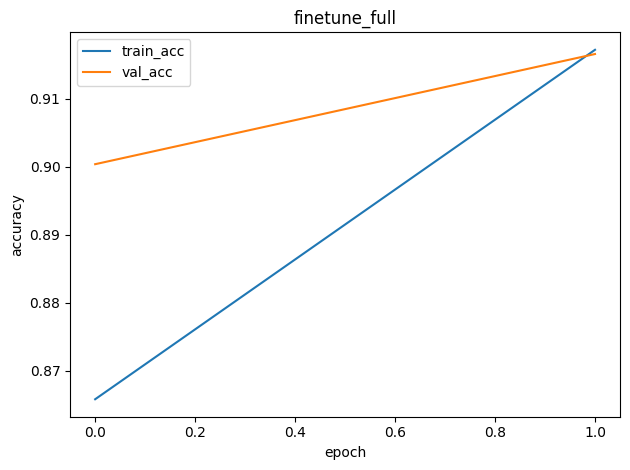

In [ ]:

dir_full = run_experiment(
    exp_name="finetune_full",
    weights="imagenet",
    train_mode="full",
    epochs=2,
    batch_size=32,
    lr=5e-4,
)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()


16195

In [ ]:
@torch.no_grad()
def load_best_model(run_dir):
    ckpt = torch.load(Path(run_dir) / "best.pt", map_location="cpu")
    cfg = ckpt["config"]
    model = build_resnet152(num_classes=10, weights=cfg["weights"])
    if cfg.get("disable_skips"):
        model = disable_skip_in_blocks(model, cfg["disable_skips"])
    model.load_state_dict(ckpt["model"])
    model.to(device)
    model.eval()
    return model, cfg

@torch.no_grad()
def extract_features(run_dir, split="val", max_samples=1500, batch_size=16):
    import gc
    torch.cuda.empty_cache()
    gc.collect()

    model, cfg = load_best_model(run_dir)
    model.eval()
    torch.set_grad_enabled(False)

    train_loader, val_loader = get_cifar10_loaders(batch_size=batch_size)
    loader = val_loader if split == "val" else train_loader

    feats = {"early": [], "mid": [], "late": []}
    labels = []

    def make_hook(key):
        def hook(module, inp, out):
            pooled = out.mean(dim=(2,3)).detach().cpu()
            feats[key].append(pooled)
        return hook

    h1 = model.layer1.register_forward_hook(make_hook("early"))
    h3 = model.layer3.register_forward_hook(make_hook("mid"))
    h4 = model.layer4.register_forward_hook(make_hook("late"))

    seen = 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        _ = model(x)
        labels.append(y.cpu())
        seen += x.size(0)
        if seen >= max_samples:
            break

    h1.remove(); h3.remove(); h4.remove()

    y = torch.cat(labels, dim=0)[:max_samples].numpy()
    out = {k: torch.cat(v, dim=0)[:max_samples].numpy() for k,v in feats.items()}
    return out, y

features, y = extract_features(dir_baseline_pre, split="val", max_samples=3000)
{k: v.shape for k,v in features.items()}, y.shape


({'early': (3000, 256), 'mid': (3000, 1024), 'late': (3000, 2048)}, (3000,))

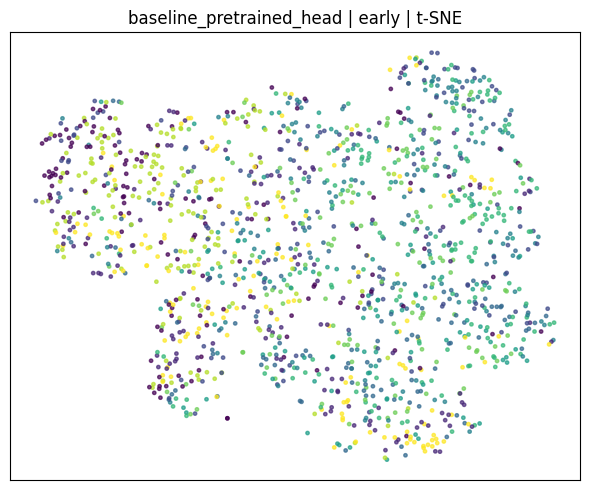

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


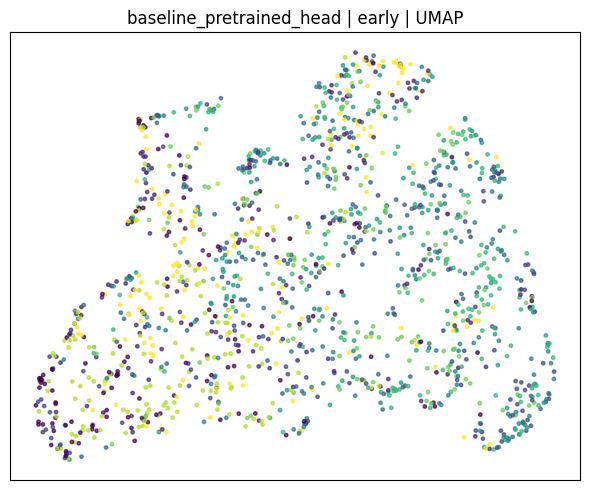

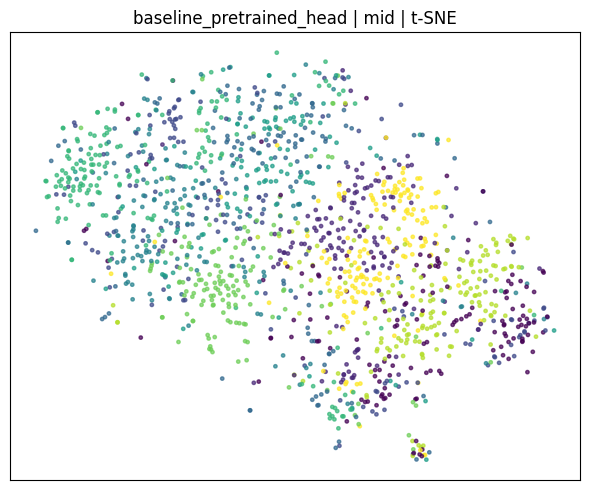

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


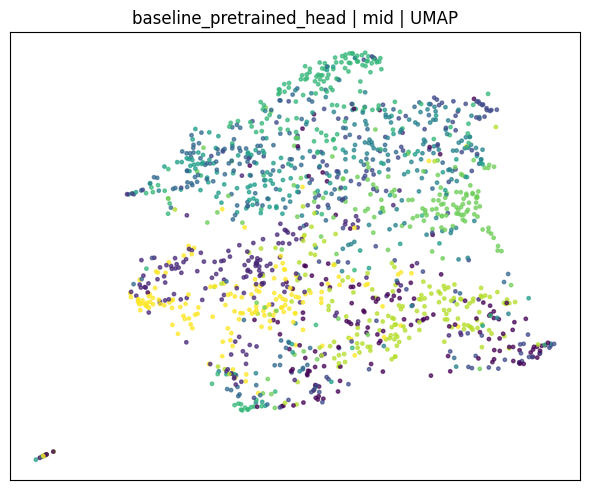

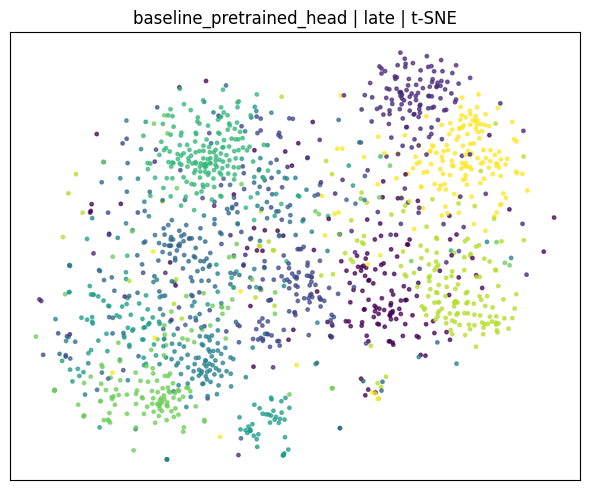

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


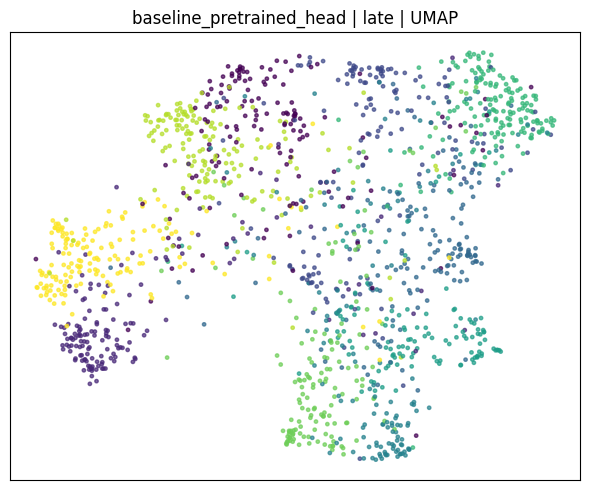

In [ ]:
def plot_2d(emb2d, y, title):
    plt.figure(figsize=(6,5))
    plt.scatter(emb2d[:,0], emb2d[:,1], c=y, s=6, alpha=0.7)
    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.show()

def reduce_and_plot(run_dir, max_samples=3000):
    features, y = extract_features(dir_baseline_pre,split="val",max_samples=1500,batch_size=16)

    for layer_name, X in features.items():
        tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=SEED)
        X_tsne = tsne.fit_transform(X)
        plot_2d(X_tsne, y, f"{Path(run_dir).name} | {layer_name} | t-SNE")

        um = umap.UMAP(n_components=2, random_state=SEED)
        X_umap = um.fit_transform(X)
        plot_2d(X_umap, y, f"{Path(run_dir).name} | {layer_name} | UMAP")

reduce_and_plot(dir_baseline_pre, max_samples=2000)

In [ ]:
import pandas as pd

def read_final_acc(run_dir):
    df = pd.read_csv(Path(run_dir)/"metrics.csv")
    return float(df["val_acc"].iloc[-1]), float(df["val_acc"].max())

runs = [dir_baseline_pre, dir_baseline_rand, dir_noskip, dir_lastblock, dir_full]
rows = []
for r in runs:
    last_acc, best_acc = read_final_acc(r)
    cfg = json.loads((Path(r)/"config.json").read_text())
    rows.append({
        "run": Path(r).name,
        "weights": cfg["weights"],
        "mode": cfg["train_mode"],
        "disable_skips": ",".join(cfg["disable_skips"]) if cfg["disable_skips"] else "",
        "val_acc_last": last_acc,
        "val_acc_best": best_acc,
    })

summary = pd.DataFrame(rows).sort_values("val_acc_best", ascending=False)
summary


,run,weights,mode,disable_skips,val_acc_last,val_acc_best
3,finetune_last_block,imagenet,last_block,,0.9375,0.9375
4,finetune_full,imagenet,full,,0.9166,0.9166
0,baseline_pretrained_head,imagenet,head_only,,0.8684,0.8684
2,noskip_layer3_5_6_7,imagenet,head_only,"layer3.5,layer3.6,layer3.7",0.1499,0.1499
1,baseline_random_head,random,head_only,,0.1345,0.1386
